In [30]:
import torch
from collections import Counter
import numpy as np
import glob
import os

In [31]:
def open_yolo_files(image_name, label_path, pred_path):
    """
    This function opens the associated .txt files with the manually marked ground truth labels
    and the predicted bounding boxes for a given image name.

    Parameters:
        image_name (str): filename of the image with path included.
        label_path (str): path to the directory with the manual annotation files.
        pred_path (str): path to the directory with the prediction files.

    Returns:
        list: all bounding boxes from the given ground truth .txt.
        list: all bounding boxes from the given predictions .txt.
    """
    try: 
        name = image_name.split("/")[-1].split(".")[0]
        label = label_path + name + ".txt"
        pred = pred_path + name + "_train_pred.txt"
        label_boxes = np.genfromtxt(label, delimiter=' ')
        #print("Ground truths")
        #print(label_boxes)
        preds_boxes = np.genfromtxt(pred, delimiter=' ')
        #print("Predictions")
        #print(preds_boxes)
        # reshaping the np array is necessary in case a file with a single box is read
        label_boxes = label_boxes.reshape(label_boxes.size//5, 5) # class, x or x1, y or x2, w or y1, h or y2
        preds_boxes = preds_boxes.reshape(preds_boxes.size//6, 6) # class, confidence, x or x1, y or x2, w or y1, h or y2
        #print(preds_boxes.shape)
        #print(label_boxes.shape)
        return label_boxes.tolist(), preds_boxes.tolist()
    except Exception as e:
        print(e)
        return None, None

In [32]:
def intersection_over_union(preds_boxes, labels_boxes, preds_format="midpoint", labels_format="midpoint"):
    """
    Video explanation of this function:
    https://youtu.be/XXYG5ZWtjj0

    This function calculates intersection over union (iou) given pred boxes
    and target boxes.

    Parameters:
        preds_boxes (numpy array): Predictions of Bounding Boxes of a given image, a list of lists
        [[class, conf, x, y, h, w], ...] if midpoint or 
        [[image_idx, class, conf, x1, y1, x2, y2], ...] if corner.
        labels_boxes (numpy array): Correct labels of Bounding Boxes of a given image, a list of lists
        [[image_idx, class, x, y, h, w], ...] if midpoint or
        [[image_idx, class, x1, y1, x2, y2], ...] if corner.
        preds_format (str): midpoint/corners, if boxes (x,y,w,h) or (x1,y1,x2,y2) for predictions
        labels_format (str): midpoint/corners, if boxes (x,y,w,h) or (x1,y1,x2,y2) for ground truths

    Returns:
        tensor: Intersection over union for all examples
    """
    if labels_format == "midpoint":
        box1_x1 = preds_boxes[..., 0:1] - preds_boxes[..., 2:3] / 2
        box1_y1 = preds_boxes[..., 1:2] - preds_boxes[..., 3:4] / 2
        box1_x2 = preds_boxes[..., 0:1] + preds_boxes[..., 2:3] / 2
        box1_y2 = preds_boxes[..., 1:2] + preds_boxes[..., 3:4] / 2
    elif labels_format == "corner":
        box1_x1 = preds_boxes[..., 0:1]
        box1_y1 = preds_boxes[..., 1:2]
        box1_x2 = preds_boxes[..., 2:3]
        box1_y2 = preds_boxes[..., 3:4]

    if preds_format == "midpoint":
        box2_x1 = labels_boxes[..., 0:1] - labels_boxes[..., 2:3] / 2
        box2_y1 = labels_boxes[..., 1:2] - labels_boxes[..., 3:4] / 2
        box2_x2 = labels_boxes[..., 0:1] + labels_boxes[..., 2:3] / 2
        box2_y2 = labels_boxes[..., 1:2] + labels_boxes[..., 3:4] / 2
    elif preds_format == "corners":
        box2_x1 = labels_boxes[..., 0:1]
        box2_y1 = labels_boxes[..., 1:2]
        box2_x2 = labels_boxes[..., 2:3]
        box2_y2 = labels_boxes[..., 3:4]

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)
    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    return intersection / (box1_area + box2_area - intersection + 1e-6)

def metrics(preds_boxes, labels_boxes, iou_threshold=0.5, preds_format="midpoint", labels_format="midpoint", num_classes=4):
    """
    Video explanation of this function:
    https://youtu.be/FppOzcDvaDI

    This function calculates:
    1) mean average precision (mAP) considering all images;
    2) number of true boxes for each class considering all bounding boxes of all images;
    3) precision for each class considering all bounding boxes of all images;
    4) recall for each class considering all bounding boxes of all images;
    5) total number of true positives bounding boxes for each class accounting all images;
    6) total number of false positive bounding boxes for each class accounting all images.

    Parameters:
        (idx is the image index)
        preds_boxes (numpy array): Predictions of Bounding Boxes of all images, a list of lists
        [[image_idx, class, conf, x, y, h, w], ...] if midpoint or 
        [[image_idx, class, conf, x1, y1, x2, y2], ...] if corner.
        labels_boxes (numpy array): Correct labels of Bounding Boxes of all images, a list of lists
        [[image_idx, class, x, y, h, w], ...] if midpoint or
        [[image_idx, class, x1, y1, x2, y2], ...] if corner.
        iou_threshold (float): threshold where predicted bboxes is correct
        box_format (str): "midpoint" or "corners" used to specify bboxes
        num_classes (int): number of classes

    Returns:
        float: mAP value across all classes given a specific IoU threshold.
        list of floats: class_true_bboxes[0...num_classes - 1] with the number of true bboxes for each class.
        list of floats: class_TP[0...num_classes - 1] with the total of TP for each class.
        list of floats: class_FP[0...num_classes - 1] with the total of FP for each class.
        list of floats: class_precision[0...num_classes - 1] with the precisions for each class.
        list of floats: class_recall[0...num_classes - 1] with the recalls for each class.
        list of lists of floats: class_precision_cumsum[[precisions 1]...[precisions num_classes-1]] with the cumulative
        sum of precisions for each class.
        list of lists of floats: class_recall_cumsum[[recalls 1]... [recalls num_classes-1]] with the cumulative sum of
        recall for each class.

    """

    # list storing all AP for respective classes
    average_precisions = []

    # used for numerical stability later on
    epsilon = 1e-6

    # this process is calculated for EACH respective class
    class_true_bboxes = [0]*num_classes
    class_TP = [0]*num_classes
    class_FP = [0]*num_classes
    class_precision = [0]*num_classes
    class_recall = [0]*num_classes
    class_f1score = [0]*num_classes
    class_precision_cumsum = [0]*num_classes
    class_recall_cumsum = [0]*num_classes

    for c in range(num_classes):
        detections = []
        ground_truths = []

        # Go through all predictions and targets,
        # and only add the ones that belong to the
        # current class c
        for detection in preds_boxes:
            #print("Prediction")
            #print(detection)
            #print(c, detection[1])
            if detection[1] == c:
                detections.append(detection)

        for true_box in labels_boxes:
            #print("Label")
            #print(true_box)
            #print(c, true_box[1])
            if true_box[1] == c:
                ground_truths.append(true_box)

        # find the amount of bboxes for each training example
        # Counter here finds how many ground truth bboxes we get
        # for each training example, so let's say img 0 has 3,
        # img 1 has 5 then we will obtain a dictionary with:
        # amount_bboxes = {0:3, 1:5}
        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        # We then go through each key, val in this dictionary
        # and convert to the following (w.r.t same example):
        # ammount_bboxes = {0:torch.tensor[0,0,0], 1:torch.tensor[0,0,0,0,0]}
        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        # sort by box probabilities which is index 2 of detections
        # 0 image_idx, 1 class, 2 conf, 3 x1, 4 x2, 5 y1, 6 y2
        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)

        # If none exists for this class then we can safely skip
        if total_true_bboxes == 0:
            #print("0 members")
            continue
        #print("Total true boxes: {}".format(total_true_bboxes))

        for detection_idx, detection in enumerate(detections):
            # Only take out the ground_truths that have the same
            # training idx as detection
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            num_gts = len(ground_truth_img)
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                # we will pass only the box coordinates, so
                # starting with 3 for ground truth labels and
                # 4 for detections
                iou = intersection_over_union(
                    preds_boxes   = torch.tensor(detection[3:]),
                    labels_boxes  = torch.tensor(gt[2:]),
                    preds_format  ="midpoint",
                    labels_format ="midpoint"
                )

                #print(iou)

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                # only detect ground truth detection once
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    # true positive and add this bounding box to seen
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1

            # if IOU is lower then the detection is a false positive
            else:
                FP[detection_idx] = 1

        class_true_bboxes[c] = total_true_bboxes
        TP_cumsum = torch.cumsum(TP, dim=0)
        class_TP[c] = int(torch.sum(TP).item())
        FP_cumsum = torch.cumsum(FP, dim=0)
        class_FP[c] = int(torch.sum(FP).item())
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = TP_cumsum / (TP_cumsum + FP_cumsum + epsilon)
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        class_precision[c] = precisions[-1].item()
        class_precision_cumsum[c] = precisions.tolist()
        #class_precision[c] = class_TP[c] / (class_TP[c] + class_FP[c] + epsilon)
        class_recall[c] = recalls[-1].item()
        class_recall_cumsum[c] = recalls.tolist()
        class_f1score[c] = 2 * (class_precision[c] * class_recall[c]) / (class_precision[c] + class_recall[c] + epsilon)
        #class_precision[c] = class_TP[c] / (total_true_bboxes + epsilon)
        # torch.trapz for numerical integration
        average_precisions.append(torch.trapz(precisions, recalls))
        #print(average_precisions)

    return (sum(average_precisions) / (len(average_precisions) + 1e-6)), class_true_bboxes, class_TP, class_FP, class_precision, class_recall, class_f1score, class_precision_cumsum, class_recall_cumsum

In [33]:
#image_path = "../yolo-station/images_bgr/"
#label_path = "../yolo-station/labels_sub/"
#pred_path = "./yolov3_preds/"
#image_path = "./images_bgr/"
#label_path = "./labels_sub/"
#pred_path = "./yolov3_preds/"

#image_list = os.path.join(os.path.join(image_path, "*.*"))
#label_list = []
#pred_list = []

#image_list = glob.glob(image_list)
#for file_name in image_list:
#    name = file_name.split("/")[-1].split(".")[0]
#    label_list.append(label_path + name + ".txt")
#    print(label_list)
#    pred_list.append(pred_path + name + ".txt")
#    print(pred_list)


In [34]:
label_path = "./train_labels/"
pred_path = "./train_pred/"

label_list = os.path.join(os.path.join(label_path, "*.*"))
label_list = glob.glob(label_list)
pred_list = []


for file_name in label_list:
    name = file_name.split("/")[-1].split(".")[0]
    pred_list.append(label_path + name + "_pred.txt")
    #print(label_list)
    #print(pred_list)


In [36]:
# lists to stores all labels and all preds for all images
labels_list = []
preds_list = []

image_idx = 0
for im in label_list:    
    image_name = im
    #print(image_name)
    labels, preds = open_yolo_files(image_name, label_path, pred_path)
    #print(labels)
    # appending the index of the image at the beginning of the lists
    if((labels is not None) and (preds is not None)):
        [i.insert(0, image_idx) for i in labels]
        [i.insert(0, image_idx) for i in preds]
        labels_list.extend(labels)
        preds_list.extend(preds)
        image_idx += 1
    else:
        print("{} not found.".format(im))
#print(labels_list[0])
#print(preds_list[0])

./train_pred/FLIR0016_rgb_train_pred.txt not found.
./train_labels/FLIR0016_rgb.txt not found.
./train_labels/FLIR0331.txt not found.
./train_labels/FLIR0331.xml.txt not found.
./train_pred/FLIR0019_rgb_train_pred.txt not found.
./train_labels/FLIR0019_rgb.txt not found.
./train_pred/FLIR0021_rgb_train_pred.txt not found.
./train_labels/FLIR0021_rgb.txt not found.
./train_pred/FLIR0014_rgb_train_pred.txt not found.
./train_labels/FLIR0014_rgb.txt not found.
./train_pred/FLIR0015_rgb_train_pred.txt not found.
./train_labels/FLIR0015_rgb.txt not found.
./train_pred/FLIR0013_rgb_train_pred.txt not found.
./train_labels/FLIR0013_rgb.txt not found.
./train_pred/FLIR0018_rgb_train_pred.txt not found.
./train_labels/FLIR0018_rgb.txt not found.
./train_pred/FLIR0012_rgb_train_pred.txt not found.
./train_labels/FLIR0012_rgb.txt not found.


In [37]:
mAP, c_boxes, c_TP, c_FP, c_precision, c_recall, c_f1score, c_precision_cumsum, c_recall_cumsum = metrics(preds_list, labels_list, iou_threshold=0.5)
print("mAP: {}\nTrue boxes per class: {}\nTP per class: {}\nFP per class: {}\nPrecision per class: {}\nRecall per class: {}\nf1 score per class: {}".format(mAP.item(), c_boxes, c_TP, c_FP, c_precision, c_recall, c_f1score))

mAP: 0.921877920627594
True boxes per class: [236, 1768, 609, 410]
TP per class: [233, 1734, 604, 397]
FP per class: [21, 179, 58, 16]
Precision per class: [0.9173228144645691, 0.9064297080039978, 0.9123867154121399, 0.9612590670585632]
Recall per class: [0.9872881174087524, 0.9807692170143127, 0.9917898178100586, 0.9682926535606384]
f1 score per class: [0.9510198895562307, 0.9421347926229571, 0.9504322348764229, 0.9647625409298676]


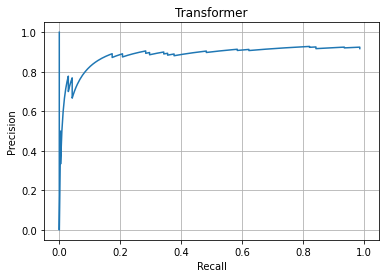

<Figure size 432x288 with 0 Axes>

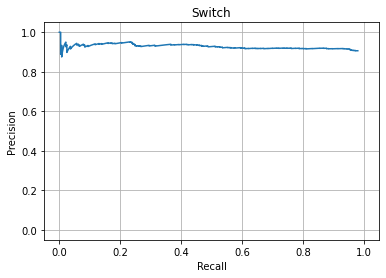

<Figure size 432x288 with 0 Axes>

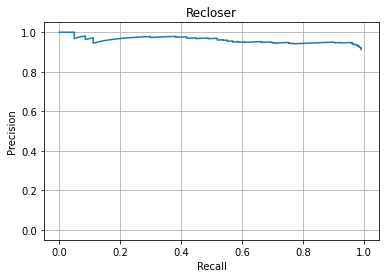

<Figure size 432x288 with 0 Axes>

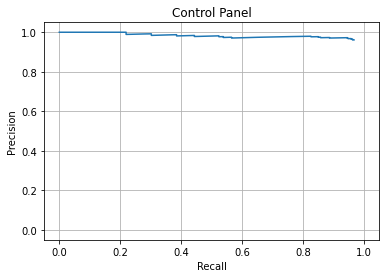

<Figure size 432x288 with 0 Axes>

In [39]:
import matplotlib.pyplot as plt
import numpy as np

classes = ["Transformer", "Switch", "Recloser", "Control Panel"]
for precision, recall, class_name in zip(c_precision_cumsum, c_recall_cumsum, classes):
    fig, ax = plt.subplots()
    plt.figure(facecolor='white')
    ax.plot(recall, precision)

    ax.set(xlabel='Recall', ylabel='Precision',
        title=class_name)
    ax.grid()
    ax.xaxis.set_data_interval(0, 1 ,True)
    ax.yaxis.set_data_interval(0, 1 ,True)

    fig.savefig("Precision x Recall - " + class_name + "_train.png")
    plt.show()